In [1]:
from sbi.inference import SNPE
from sbi.inference import SNLE
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
import torch
from sbi import analysis as analysis
import seaborn as sns
import statistics
import scipy.stats
from torch import tensor
from torch.distributions.constraints import Constraint
import torch.distributions.constraints as constraints
from torch.distributions import Uniform, Distribution
import logging
from torch.distributions.log_normal import LogNormal
from sbi.inference.posteriors.direct_posterior import DirectPosterior
from sklearn.preprocessing import StandardScaler
from torch.distributions import MultivariateNormal

In [2]:
filename = "./observed_stats.csv"
x_o = torch.tensor(np.float32(np.genfromtxt(filename, delimiter=',', dtype=float)))
filename2 = "./summary_stats_r2.csv"
x = torch.tensor(np.float32(np.genfromtxt(filename2, delimiter=',', dtype=float)))
filename3 = "./thetas_r2.csv"
theta = torch.tensor(np.float32(np.genfromtxt(filename3, delimiter=',', dtype=float)))

#### Prior predictive checks

In [5]:
names = np.genfromtxt("./statnames.csv", delimiter=',', dtype=str)
names[0] = "diversity_domestic"

In [ ]:
for col in range(0,135):
    
    plt.hist(x[:, col],
         alpha=0.5,
         label='round 1', bins=100)
    
   # plt.hist(x2[:, col],
    #     alpha=0.5,
    #     label='round 2', bins=50)

    plt.axvline(x = x_o[col], color = 'r', label = 'x_o')
  
    plt.legend(loc='upper right')
    plt.title(names[col])
    plt.show()

#### For first round:

In [59]:
x_scaler = StandardScaler()
x_o = torch.reshape(x_o, (1, -1))
combined_x = torch.cat((x_o, x))
combined_x_t = x_scaler.fit_transform(combined_x)
x_t = torch.tensor(np.float32(combined_x_t[1:len(combined_x_t)]))
x_o_t = torch.tensor(np.float32(combined_x_t[0]))

In [60]:
log_theta = torch.log(theta)
theta_scaler = StandardScaler()
theta_t = theta_scaler.fit_transform(log_theta)
theta_t = torch.tensor(np.float32(theta_t))

#### Then save the scaler models:

In [5]:
with open('./theta_scaler.pkl','wb') as f:
    pickle.dump(theta_scaler, f)

In [13]:
with open('./x_scaler.pkl','wb') as f:
    pickle.dump(x_scaler, f)

#### Then for subsequent rounds:

In [3]:
with open('./x_scaler.pkl','rb') as f:
    x_scaler = pickle.load(f)

x_o = torch.reshape(x_o, (1, -1))
combined_x = torch.cat((x_o, x))
combined_x_t = x_scaler.transform(combined_x)
x_t = torch.tensor(np.float32(combined_x_t[1:len(combined_x_t)]))
x_o_t = torch.tensor(np.float32(combined_x_t[0]))

In [4]:
with open('./theta_scaler.pkl','rb') as f:
    theta_scaler = pickle.load(f)
log_theta = torch.log(theta)
theta_t = theta_scaler.transform(log_theta)
theta_t = torch.tensor(np.float32(theta_t))

#### For sequential: load prior

In [5]:
proposal_r1 = torch.load("./proposal_r1.pt")

In [6]:
prior = MultivariateNormal(loc=torch.zeros(16), scale_tril=torch.diag(torch.ones(16)))

In [ ]:
inference = SNPE(prior=prior, density_estimator='maf')
inference = inference.append_simulations(theta_t, x_t, proposal=proposal_r1)
density_estimator = inference.train(show_train_summary=True, 
                                    use_combined_loss=True, 
                                    training_batch_size=200)
posterior = inference.build_posterior(density_estimator)
proposal = posterior.set_default_x(x_o_t)

Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 67

In [8]:
torch.save(proposal, "./proposal_r2.pt")

#### avg. log prob. for MAF:

In [213]:
logs_s = []
for sim in range(8001,9001):
    log = posterior.log_prob(theta=theta_t[sim], x=x_t[sim])
    logs_s.append(log)
logs = torch.cat(logs_s)
torch.mean(logs)

tensor(-5.9796)

#### avg. log prob. for MDN:

In [215]:
logs_s = []
for sim in range(8001,9001):
    log = posterior.log_prob(theta=theta_t[sim], x=x_t[sim])
    logs_s.append(log)
logs = torch.cat(logs_s)
torch.mean(logs)

tensor(-10.8160)

In [194]:
### MAP for final proposal:
map_array = torch.reshape(proposal.map(), (1, -1))
np.exp(theta_scaler.inverse_transform(map_array))

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

array([[1.48969441e+01, 2.90831157e+05, 3.80766122e+03, 4.51339154e+03,
        4.27261249e-02, 5.48782886e-02, 1.81708928e+01, 1.09169148e+02,
        1.24069555e+05, 4.92387189e+03, 9.32893118e+04, 6.82929725e+03,
        7.38126525e+03, 1.51745624e+04, 9.38917107e-09, 1.66682815e-08]])

In [131]:
proposal_r2 = posterior.set_default_x(x_o_t)
torch.save(proposal_r2, "./proposal_real.pt")

DirectPosterior sampler for potential_fn=<PosteriorBasedPotential>

In [269]:
samples = posterior.sample((10000,), x=x_o_t)
samples = theta_scaler.inverse_transform(samples)
samples = torch.tensor(np.float32(samples))
samples = torch.exp(samples)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [77]:
params_df = samples.numpy()
params_df = pd.DataFrame(params_df)
params_df.to_csv("params_r3_final_big.csv", index=False)

In [8]:
dims = [
    "$\mathregular{T_4}$",
    "$\mathregular{T_1}$",
    "$\mathregular{T_2}$",
    "$\mathregular{T_3}$",
    "$\mathregular{M_2}$",
    "$\mathregular{M_1}$",
    "t",
    "$\mathregular{N_1}$",
    "$\mathregular{N_4}$",
    "$\mathregular{N_5}$",
    "$\mathregular{N_7}$",
    "$\mathregular{N_2}$",
    "$\mathregular{N_3}$",
    "$\mathregular{N_6}$",
    "m",
    "r"]

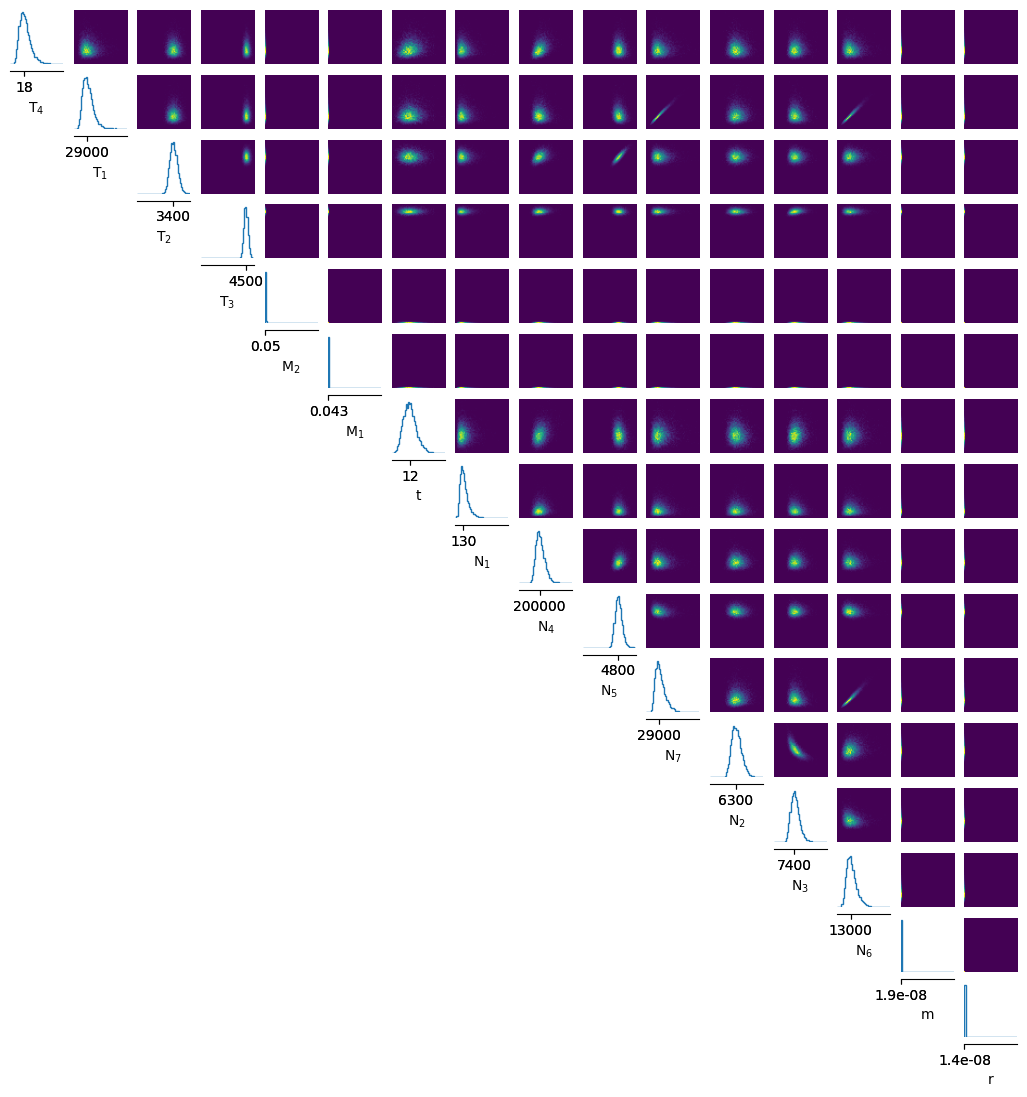

In [13]:
values = torch.tensor(values)
values = torch.reshape(values, (16,1))
ticks = torch.cat((values,values), dim=1)
_ = analysis.pairplot(samples, labels=dims, figsize=(13,13), ticks=ticks)

#### Save next round parameters

In [19]:
params_df = samples.numpy()
params_df = pd.DataFrame(params_df)
params_df.to_csv("params_r3.csv", index=False)

In [6]:
from math import log10, floor
def round_sig(x, sig=2):
    return round(x, sig-int(floor(log10(abs(x))))-1)

In [4]:
samplesn = samples.numpy()

In [7]:
values = []
for col in range(0,16):
    median = statistics.median(samplesn[:,col])
    rounded = round_sig(median)
    values.append(rounded)

In [11]:
names = ["captive_time",
        "div_time",
        "div_time_dom",
        "div_time_scot",
        "mig_rate_captive",
        "mig_rate_scot",
        "mig_length_scot",
        "pop_size_captive",
        "pop_size_domestic_1",
        "pop_size_lyb_1",
        "pop_size_lyb_2",
        "pop_size_scot_1",
        "pop_size_eu_1",
        "pop_size_eu_2",
        "mutation_rate",
        "recombination_rate"
        ]

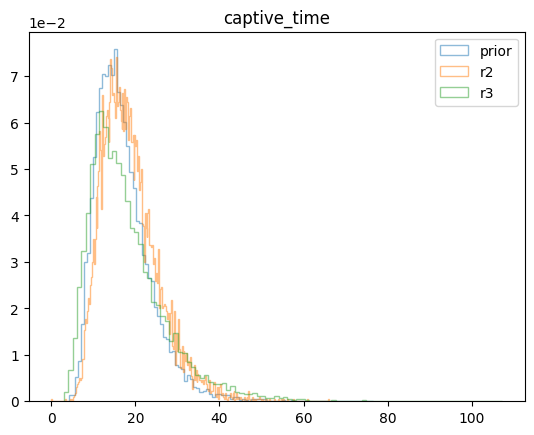

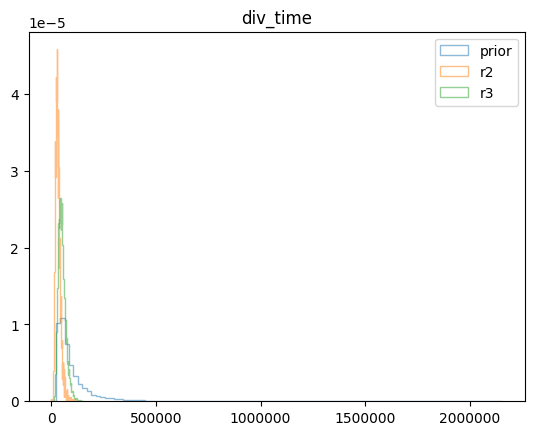

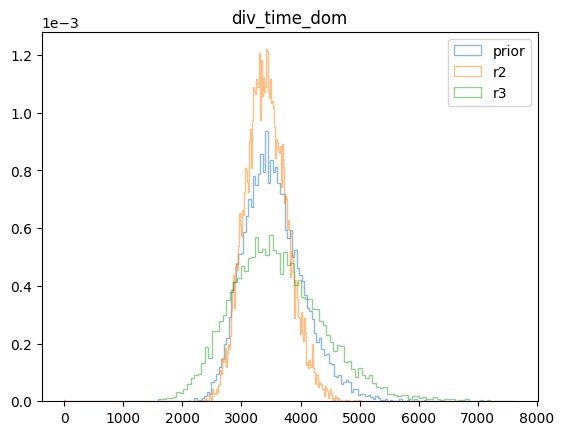

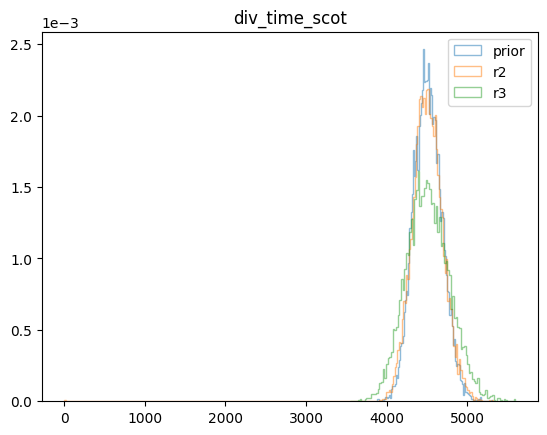

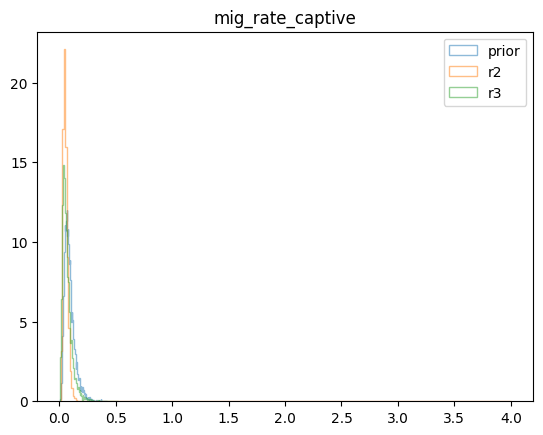

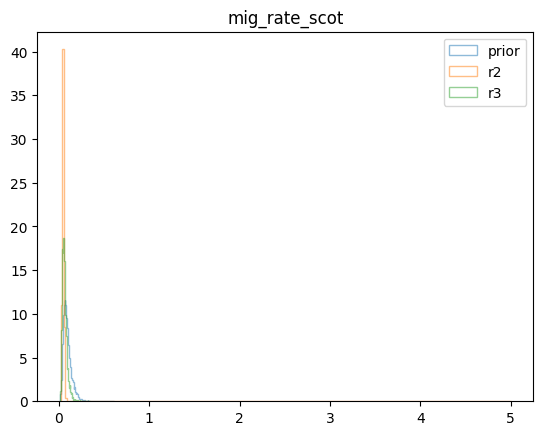

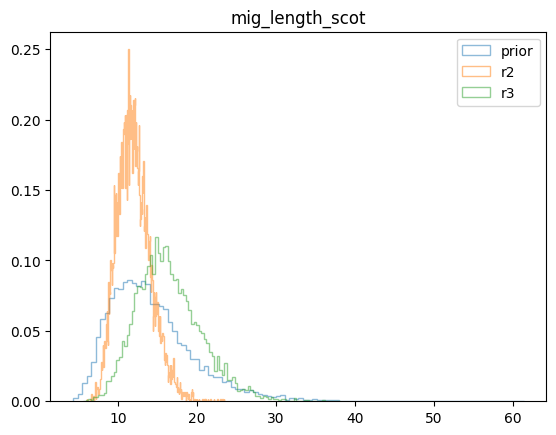

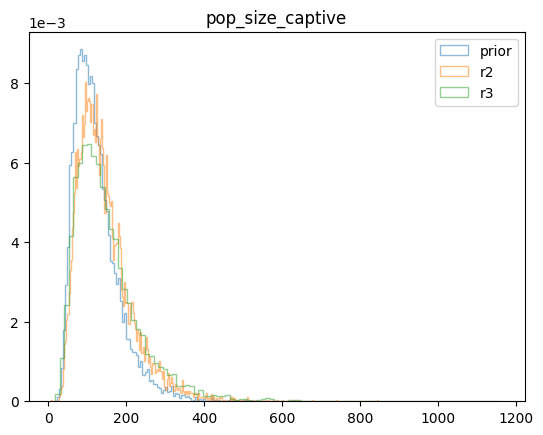

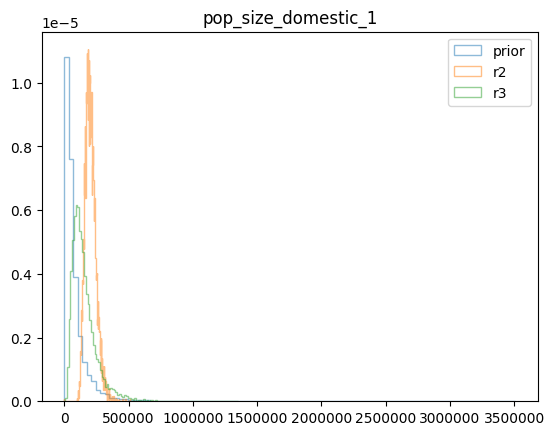

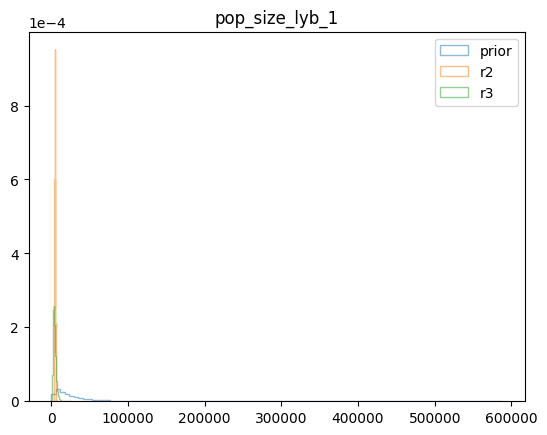

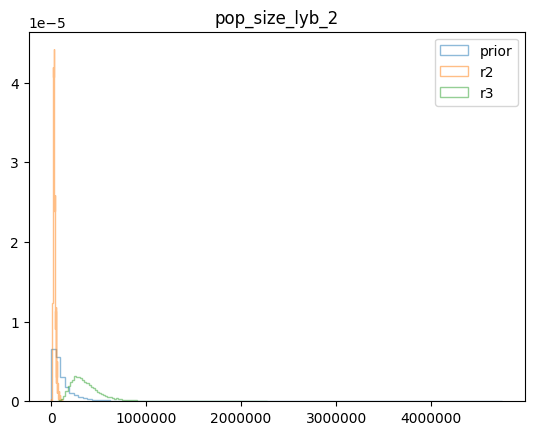

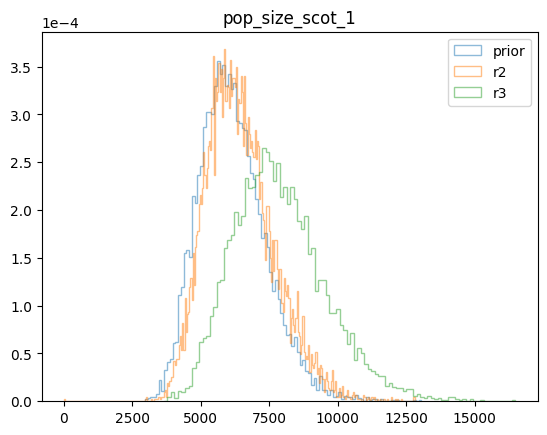

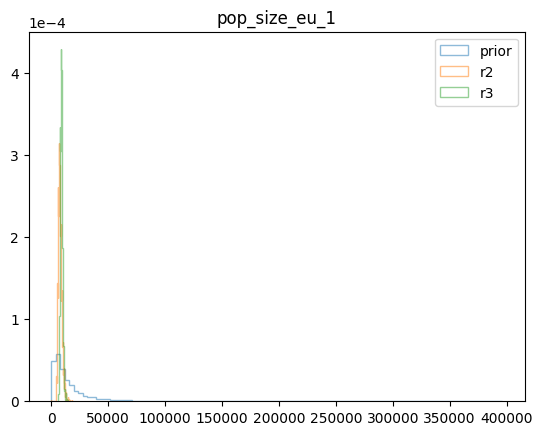

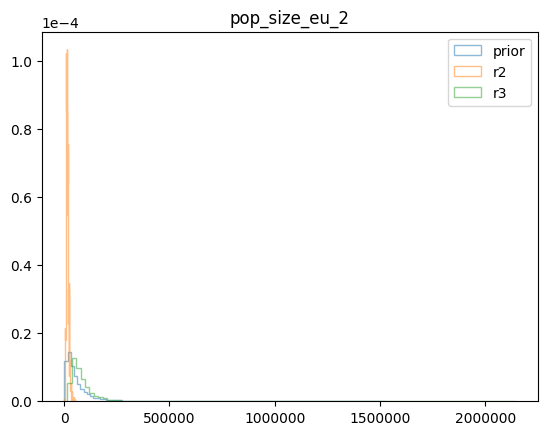

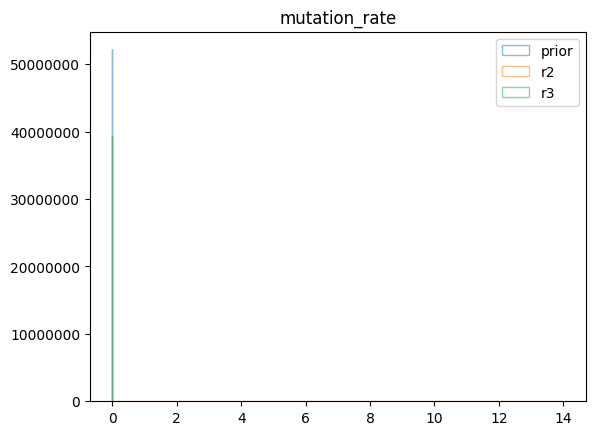

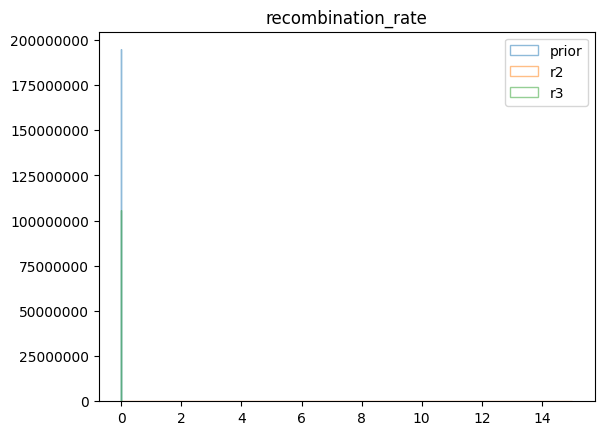

In [270]:
for num in range(0,16):  
    plt.hist(prior_r1[num][0:10000],
             alpha=0.5,
             label='prior', bins=100, density=True, histtype='step')
    
    plt.hist(theta_r2_big[0:10000, num],
             alpha=0.5,
             label='r2', bins=300, density=True, histtype='step')

    plt.hist(samples[0:10000, num],
             alpha=0.5,
             label='r3', bins=100, density=True, histtype='step')

    plt.legend(loc='upper right')
    plt.title(names[num])
    #plt.yticks([])
    #plt.xlim([0,0.2])
    #plt.xlim([min(theta_r2_big[0:10000, num]), max(theta_r2_big[0:10000, num])])
    plt.show()

In [ ]:
for num in range(0,13):   
    plt.hist(prior_r1[num][0:10000],
             alpha=0.5,
             label='round_1', bins=100, density=True, histtype='step')

    plt.hist(p2[0:10000, num],
             alpha=0.5,
             label='round_2', bins=100, density=True, histtype='step')

    plt.hist(p3[0:10000, num], 
             alpha=0.5, # the transaparency parameter
             label='round_3', bins=100, density=True, histtype='step')

    plt.legend(loc='upper right')
    plt.title(names[num])
    #plt.yticks([])
    #plt.xlim([0, 100])
    plt.show()

In [529]:
filename4 = "./params_r2_alt_big.csv"
p2 = torch.tensor(np.float32(np.genfromtxt(filename4, delimiter=',', dtype=float)))
filename5 = "./params_r3_temp.csv"
p3 = torch.tensor(np.float32(np.genfromtxt(filename5, delimiter=',', dtype=float)))

In [181]:
theta_r2_big[:,14]

tensor([1.4000e+01, 1.1348e-08, 1.0041e-08,  ..., 3.3118e-08, 1.1973e-08,
        1.1962e-08])

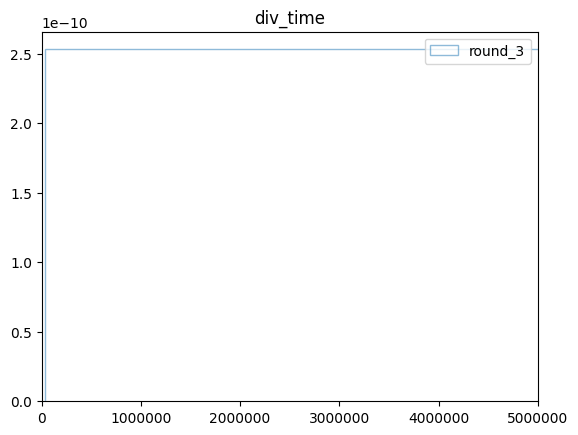

In [267]:
num=1
#plt.hist(prior_r1[num][0:10000],
#         alpha=0.5,
#         label='round_1', bins=100, density=True, histtype='step')

#plt.hist(theta_r2_big[0:10000, num],
#         alpha=0.5,
#         label='round_2', bins=100, density=True, histtype='step')

plt.hist(samples[0:10000, num], 
         alpha=0.5, # the transaparency parameter
         label='round_3', bins=100, density=True, histtype='step')


plt.legend(loc='upper right')
plt.title(names[num])
#plt.yticks([])
plt.xlim([0, 5000000])
plt.show()

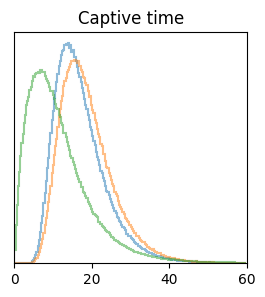

In [230]:
plt.figure(figsize=(3,3))
plt.rcParams['axes.formatter.limits'] = [-2, 10]
plt.hist(prior_r1[0][0:1000000],
         alpha=0.5,
         label='P', bins=np.arange(0, 60, 0.3), density=True, histtype='step', linewidth=1.5)

plt.hist(theta_r2_big[0:1000000, 0],
         alpha=0.5,
         label='R1', bins=np.arange(0, 60, 0.3), density=True, histtype='step', linewidth=1.5)

plt.hist(theta_r3_big[0:1000000, 0],
         alpha=0.5,
         label='R2', bins=np.arange(0, 60, 0.3), density=True, histtype='step', linewidth=1.5)

#plt.legend(loc='upper right')
#plt.title("$\mathregular{T4}$")
plt.title("Captive time")
plt.yticks([])
plt.xlim([0, 60])
plt.show()

In [ ]:
plt.figure(figsize=(3,3))
plt.rcParams['axes.formatter.limits'] = [-2, 10]
plt.hist(prior_r1[1][0:1000000],
         alpha=0.5,
         label='P', bins=np.arange(0, 400000, 1000), density=True, histtype='stepfilled', linewidth=1.5)

plt.hist(theta_r2_big[0:1000000, 1],
         alpha=0.5,
         label='R1', bins=np.arange(0, 400000, 1000), density=True, histtype='stepfilled', linewidth=1.5)

plt.hist(theta_r3_big[0:1000000, 1],
         alpha=0.5,
         label='R2', bins=np.arange(0, 400000, 1000), density=True, histtype='stepfilled', linewidth=1.5)

plt.legend(loc='upper right', bbox_to_anchor=(2, 2), fontsize=20)
#plt.title("$\mathregular{T_1}$")
plt.title("$F. lybica$ divergence")
plt.yticks([])
plt.xlim([0, 400000])
plt.show()

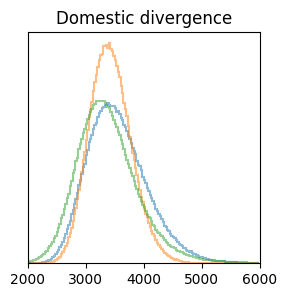

In [166]:
plt.figure(figsize=(3,3))
#plt.rcParams['axes.formatter.limits'] = [-2, 10]
plt.hist(prior_r1[2][0:1000000],
         alpha=0.5,
         label='round_1', bins=np.arange(1000, 6000, 25), density=True, histtype='step', linewidth=1.5)

plt.hist(theta_r2_big[0:1000000, 2],
         alpha=0.5,
         label='round_2', bins=np.arange(1000, 6000, 25), density=True, histtype='step', linewidth=1.5)

plt.hist(theta_r3_big[0:1000000, 2],
         alpha=0.5,
         label='R2', bins=np.arange(1000, 6000, 25), density=True, histtype='step', linewidth=1.5)

#plt.legend(loc='upper right')
#plt.title("$\mathregular{T_2}$")
plt.title("Domestic divergence")
plt.yticks([])
plt.xlim([2000, 6000])
plt.show()

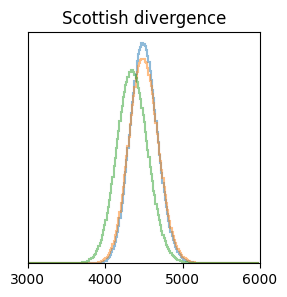

In [229]:
plt.figure(figsize=(3,3))
plt.rcParams['axes.formatter.limits'] = [-2, 100]
plt.hist(prior_r1[3][0:1000000],
         alpha=0.5,
         label='round_1', bins=np.arange(3000, 6000, 15), density=True, histtype='step', linewidth=1.5)

plt.hist(theta_r2_big[0:1000000, 3],
         alpha=0.5,
         label='round_2', bins=np.arange(3000, 6000, 15), density=True, histtype='step', linewidth=1.5)

plt.hist(theta_r3_big[0:1000000, 3],
         alpha=0.5,
         label='R2', bins=np.arange(3000, 6000, 15), density=True, histtype='step', linewidth=1.5)

#plt.legend(loc='upper right')
#plt.title("$\mathregular{T_3}$")
plt.title("Scottish divergence")
plt.yticks([])
plt.xlim([3000, 6000])
plt.show()

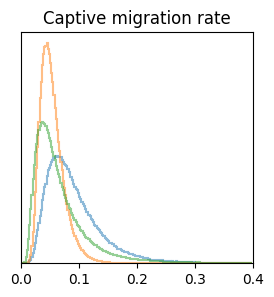

In [161]:
plt.figure(figsize=(3,3))
plt.rcParams['axes.formatter.limits'] = [-2, 10]
plt.hist(prior_r1[4][0:500000],
         alpha=0.5,
         label='round_1', bins=np.arange(0, 0.4, 0.002), density=True, histtype='step', linewidth=1.5)

plt.hist(theta_r2_big[0:500000, 4],
         alpha=0.5,
         label='round_2', bins=np.arange(0, 0.4, 0.002), density=True, histtype='step', linewidth=1.5)

plt.hist(theta_r3_big[0:1000000, 4],
         alpha=0.5,
         label='R2', bins=np.arange(0, 0.4, 0.002), density=True, histtype='step', linewidth=1.5)

#plt.legend(loc='upper right')
#plt.title("$\mathregular{M_2}$")
plt.title("Captive migration rate")
plt.yticks([])
plt.xlim([0, 0.4])
plt.show()

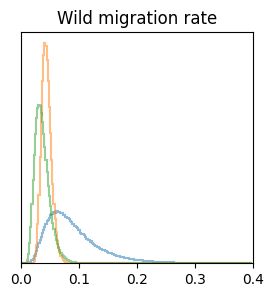

In [162]:
plt.figure(figsize=(3,3))
plt.rcParams['axes.formatter.limits'] = [-2, 10]
plt.hist(prior_r1[5][0:500000],
         alpha=0.5,
         label='round_1', bins=np.arange(0, 0.4, 0.002), density=True, histtype='step', linewidth=1.5)

plt.hist(theta_r2_big[0:500000, 5],
         alpha=0.5,
         label='round_2', bins=np.arange(0, 0.4, 0.002), density=True, histtype='step', linewidth=1.5)

plt.hist(theta_r3_big[0:1000000, 5],
         alpha=0.5,
         label='R2', bins=np.arange(0, 0.4, 0.002), density=True, histtype='step', linewidth=1.5)

#plt.legend(loc='upper right')
#plt.title("$\mathregular{M_1}$")
plt.title("Wild migration rate")
plt.yticks([])
plt.xlim([0, 0.4])
plt.show()

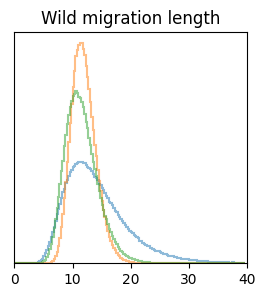

In [164]:
plt.figure(figsize=(3,3))
plt.hist(prior_r1[6][0:1000000],
         alpha=0.5,
         label='round_1', bins=np.arange(0, 40, 0.25), density=True, histtype='step', linewidth=1.5)

plt.hist(theta_r2_big[0:1000000, 6],
         alpha=0.5,
         label='round_2', bins=np.arange(0, 40, 0.25), density=True, histtype='step', linewidth=1.5)

plt.hist(theta_r3_big[0:1000000, 6],
         alpha=0.5,
         label='R2', bins=np.arange(0, 40, 0.25), density=True, histtype='step', linewidth=1.5)

#plt.legend(loc='upper right')
#plt.title("t")
plt.title("Wild migration length")
plt.yticks([])
plt.xlim([0, 40])
plt.show()

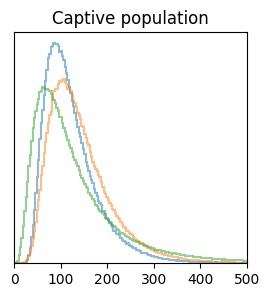

In [202]:
plt.figure(figsize=(3,3))
plt.hist(prior_r1[7][0:700000],
         alpha=0.5,
         label='round_1', bins=np.arange(0, 500, 3), density=True, histtype='step', linewidth=1.5)

plt.hist(theta_r2_big[0:700000, 7],
         alpha=0.5,
         label='round_2', bins=np.arange(0, 500, 3), density=True, histtype='step', linewidth=1.5)

plt.hist(theta_r3_big[0:1000000, 7],
         alpha=0.5,
         label='R2', bins=np.arange(0, 500, 3), density=True, histtype='step', linewidth=1.5)

#plt.legend(loc='upper right')
#plt.title("$\mathregular{N_1}$")
plt.title("Captive population")
plt.yticks([])
plt.xlim([0, 500])
plt.show()

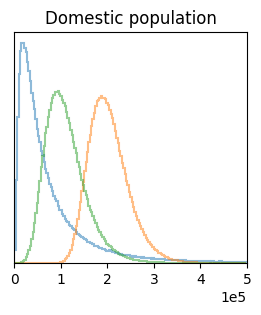

In [228]:
plt.figure(figsize=(3,3))
plt.rcParams['axes.formatter.limits'] = [-1, 1]
plt.hist(prior_r1[8][0:700000],
         alpha=0.5,
         label='round_1', bins=np.arange(0, 500000, 3000), density=True, histtype='step', linewidth=1.5)

plt.hist(theta_r2_big[0:700000, 8],
         alpha=0.5,
         label='round_2', bins=np.arange(0, 500000, 3000), density=True, histtype='step', linewidth=1.5)

plt.hist(theta_r3_big[0:1000000, 8],
         alpha=0.5,
         label='R2', bins=np.arange(0, 500000, 3000), density=True, histtype='step', linewidth=1.5)

#plt.legend(loc='upper right')
#plt.title("$\mathregular{N_4}$")
plt.title("Domestic population")
plt.yticks([])
plt.xlim([0, 500000])
plt.show()

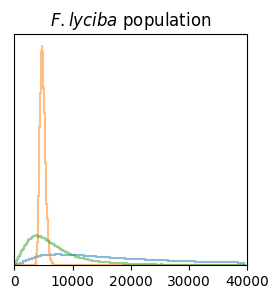

In [215]:
plt.figure(figsize=(3,3))
plt.hist(prior_r1[9][0:700000],
         alpha=0.5,
         label='round_1', bins=np.arange(0, 40000, 500), density=True, histtype='step', linewidth=1.5)

plt.hist(theta_r2_big[0:700000, 9],
         alpha=0.5,
         label='round_2', bins=np.arange(0, 40000, 100), density=True, histtype='step', linewidth=1.5)

plt.hist(theta_r3_big[0:1000000, 9],
         alpha=0.5,
         label='R2', bins=np.arange(0, 40000, 100), density=True, histtype='step', linewidth=1.5)

#plt.legend(loc='upper right')
plt.title("$\mathregular{N_5}$")
plt.title("$F. lyciba$ population")
plt.yticks([])
plt.xlim([0, 40000])
plt.show()

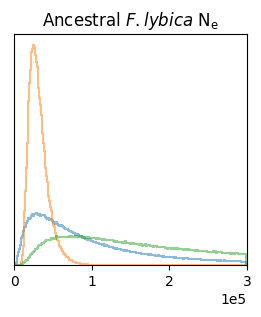

In [225]:
plt.figure(figsize=(3,3))
plt.hist(prior_r1[10][0:700000],
         alpha=0.5,
         label='round_1', bins=np.arange(0, 300000, 1000), density=True, histtype='step', linewidth=1.5)

plt.hist(theta_r2_big[0:700000, 10],
         alpha=0.5,
         label='round_2', bins=np.arange(0, 300000, 1000), density=True, histtype='step', linewidth=1.5)

plt.hist(theta_r3_big[0:1000000, 10],
         alpha=0.5,
         label='R2', bins=np.arange(0, 300000, 1000), density=True, histtype='step', linewidth=1.5)

#plt.legend(loc='upper right')
plt.title("$\mathregular{N_7}$")
plt.title("Ancestral $F. lybica$ $\mathregular{N_e}$")
plt.yticks([])
plt.xlim([0, 300000])
plt.show()

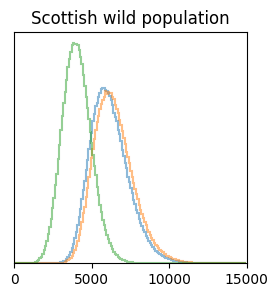

In [217]:
plt.figure(figsize=(3,3))
plt.hist(prior_r1[11][0:1000000],
         alpha=0.5,
         label='round_1', bins=np.arange(0, 15000, 90), density=True, histtype='step', linewidth=1.5)

plt.hist(theta_r2_big[0:1000000, 11],
         alpha=0.5,
         label='round_2', bins=np.arange(0, 15000, 90), density=True, histtype='step', linewidth=1.5)

plt.hist(theta_r3_big[0:1000000, 11],
         alpha=0.5,
         label='R2', bins=np.arange(0, 15000, 90), density=True, histtype='step', linewidth=1.5)

#plt.legend(loc='upper right')
#plt.title("$\mathregular{N_2}$")
plt.title("Scottish wild population")
plt.yticks([])
plt.xlim([0, 15000])
plt.show()

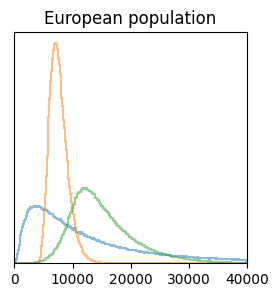

In [218]:
plt.figure(figsize=(3,3))
plt.hist(prior_r1[12][0:1000000],
         alpha=0.5,
         label='round_1', bins=np.arange(0, 40000, 150), density=True, histtype='step', linewidth=1.5)

plt.hist(theta_r2_big[0:1000000, 12],
         alpha=0.5,
         label='round_2', bins=np.arange(0, 40000, 150), density=True, histtype='step', linewidth=1.5)

plt.hist(theta_r3_big[0:1000000, 12],
         alpha=0.5,
         label='R2', bins=np.arange(0, 40000, 150), density=True, histtype='step', linewidth=1.5)

#plt.legend(loc='upper right')
#plt.title("$\mathregular{N_3}$")
plt.title("European population")
plt.yticks([])
plt.xlim([0, 40000])
plt.show()

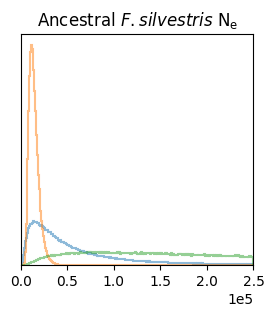

In [224]:
plt.figure(figsize=(3,3))
plt.rcParams['axes.formatter.limits'] = [-1, 1]
plt.hist(prior_r1[13][0:700000],
         alpha=0.5,
         label='round_1', bins=np.arange(0, 250000, 600), density=True, histtype='step', linewidth=1.5)

plt.hist(theta_r2_big[0:700000, 13],
         alpha=0.5,
         label='round_2', bins=np.arange(0, 250000, 500), density=True, histtype='step', linewidth=1.5)

plt.hist(theta_r3_big[0:1000000, 13],
         alpha=0.5,
         label='R2', bins=np.arange(0, 250000, 500), density=True, histtype='step', linewidth=1.5)

#plt.legend(loc='upper right')
#plt.title("$\mathregular{N_6}$")
plt.title("Ancestral $F. silvestris$ $\mathregular{N_e}$")
plt.yticks([])
plt.xlim([0, 250000])
plt.show()

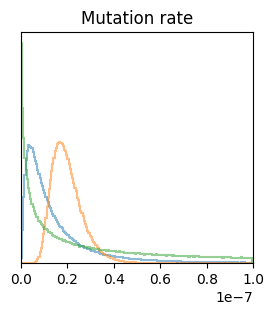

In [226]:
plt.figure(figsize=(3,3))
plt.hist(prior_r1[14][0:700000],
         alpha=0.5,
         label='round_1', bins=np.arange(0, 1e-7, 5e-10), density=True, histtype='step', linewidth=1.5)

plt.hist(theta_r2_big[0:700000, 14],
         alpha=0.5,
         label='round_2', bins=np.arange(0, 1e-7, 5e-10), density=True, histtype='step', linewidth=1.5)

plt.hist(theta_r3_big[0:1000000, 14],
         alpha=0.5,
         label='R2', bins=np.arange(0, 1e-7, 5e-10), density=True, histtype='step', linewidth=1.5)

#plt.legend(loc='upper right')
#plt.title("m")
plt.title("Mutation rate")
plt.yticks([])
plt.xlim([0, 1e-7])
plt.show()

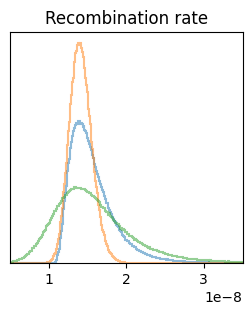

In [227]:
plt.figure(figsize=(3,3))
plt.hist(prior_r1[15][0:1000000],
         alpha=0.5,
         label='round_1', bins=np.arange(0.5e-8, 3.5e-8, 1e-10), density=True, histtype='step', linewidth=1.5)

plt.hist(theta_r2_big[0:1000000, 15],
         alpha=0.5,
         label='round_2', bins=np.arange(0.5e-8, 3.5e-8, 1e-10), density=True, histtype='step', linewidth=1.5)

plt.hist(theta_r3_big[0:1000000, 15],
         alpha=0.5,
         label='R2', bins=np.arange(0.5e-8, 3.5e-8, 1e-10), density=True, histtype='step', linewidth=1.5)

#plt.legend(loc='upper right')
#plt.title("r")
plt.title("Recombination rate")
plt.yticks([])
plt.xlim([0.5e-8, 3.5e-8])
plt.show()

In [143]:
priors_dict ={
    "captive_time": scipy.stats.lognorm(s=0.4, loc=1, scale=np.exp(2.7)),
    "div_time": scipy.stats.lognorm(s=1, loc=20000, scale=50000),
    "div_time_dom": scipy.stats.lognorm(s=0.2, loc=1000, scale=2500),
    "div_time_scot": scipy.stats.lognorm(s=0.05, loc=1000, scale=3500),
    "mig_rate_captive": scipy.stats.lognorm(s=0.5, loc=0, scale=0.08),
    "mig_rate_scot": scipy.stats.lognorm(s=0.5, loc=0, scale=0.08),
    "mig_length_scot": scipy.stats.lognorm(s=0.4, loc=1, scale=np.exp(2.5)),
    "pop_size_captive": scipy.stats.lognorm(s=0.5, loc=10, scale=100),
    "pop_size_domestic_1": scipy.stats.lognorm(s=1, loc=0, scale=50000),
    "pop_size_lyb_1": scipy.stats.lognorm(s=1, loc=0, scale=20000),
    "pop_size_lyb_2": scipy.stats.lognorm(s=1, loc=0, scale=80000),
    "pop_size_scot_1": scipy.stats.lognorm(s=0.2, loc=30, scale=np.exp(8.7)),
    "pop_size_eu_1": scipy.stats.lognorm(s=1, loc=0, scale=10000),
    "pop_size_eu_2": scipy.stats.lognorm(s=1, loc=0, scale=40000),
    "mutation_rate": scipy.stats.lognorm(s=1, loc=0, scale=1.e-8),
    "recombination_rate": scipy.stats.lognorm(s=0.5, loc=1e-8, scale=5.0e-9),
}

prior_r1 = []
for key, prior in priors_dict.items():
    prior_r1.append(prior.rvs(1000000))
prior_r1[0][0:100000]

array([21.71182363, 26.26647006,  8.17568428, ..., 24.38025729,
       33.98859269, 15.51396974])